# Phast - Time-Varying Jet Fire and Radiation
Many engineers are interested in jet fire and radiation modelling at specific times of interest in the discharge of a leak from a vessel. This is especially true when the project relates to asset risk / damage, including escalation to other process equipment, safety related equipment, buildings, escapes routes, muster areas and much more. The Phast APIs support this very easily...

## Import the required items

In [1]:
import {
  VesselStateCalculation,
  VesselLeakCalculation
} from "./src/calculations/discharge";

import { JetFireCalculation } from "./src/calculations/jetFire";

import { DistancesAndEllipsesToRadiationLevelsCalculation } from "./src/calculations/radiation";

import {
  State,
  Material,
  Vessel,
  Leak,
  DischargeParameters,
  FlammableParameters,
  FlammableOutputConfig,
  Weather,
  Substrate
} from "./src/entities";

import {
  ResultCode,
  FluidSpec,
  MixtureModelling,
  TimeVaryingOption
} from "./src/enums";

import { setAccessToken } from "./src/utilities";
import { getMaterialByName } from "./src/materials";
import Plotly from "tslab-plotly";
import * as tslab from "tslab";

// Set up access token
const accessToken = process.env.PWS_ACCESS_TOKEN;
if (!accessToken) {
  throw new Error("PWS_ACCESS_TOKEN environment variable is not set.");
}
setAccessToken(accessToken);

## Running discharge calculations

### Define the input data
Define some input data. Units are in S.I.

In [2]:
const material = await getMaterialByName("METHANE");
const pressure = 12000000;
const temperature = 293.15;
const holeDiameter = 0.05;

### Calculate the vessel conditions
Determine the conditions inside the vessel...

In [3]:
const state = new State({
  pressure: pressure,
  temperature: temperature,
  liquidFraction: 0,
  flashFlag: FluidSpec.TP,
  mixtureModelling: MixtureModelling.PC
});

const vesselStateCalculation = new VesselStateCalculation(material, state);

const resultCode = await vesselStateCalculation.run();

if (resultCode === ResultCode.SUCCESS) {
    console.log("Vessel state calculation successful.");
    console.log("The vessel conditions are " + vesselStateCalculation.vesselConditions);
    
    var vesselConditions = vesselStateCalculation.vesselConditions;
} else {
    console.log("Vessel state calculation failed.");
}

Vessel state calculation successful.
The vessel conditions are 1


### Calculate the discharge
Use the VesselLeakCalculation class to model a time-varying discharge...

In [4]:
const vessel = new Vessel({
  state: state,
  material: material,
  liquidFillFractionByVolume: 0,
  vesselConditions: vesselStateCalculation.vesselConditions
});

const leak = new Leak({
  holeDiameter: holeDiameter,
  timeVaryingOption: TimeVaryingOption.TIME_VARYING_RATE
});

const dischargeParameters = new DischargeParameters();

const vesselLeakCalculation = new VesselLeakCalculation(
  vessel,
  leak,
  dischargeParameters
);

const resultCode2 = await vesselLeakCalculation.run();

if (resultCode2 === ResultCode.SUCCESS) {
    console.log("Discharge calculations successful.");
} else {
    console.log("Discharge calculations failed.");
}

Discharge calculations successful.


### Review the discharge results
Let's print a few discharge records...

In [5]:
for (let r = 0; r < 3; r++) {
    const record = vesselLeakCalculation.dischargeRecords![r];
    console.log(`Time: ${record.time.toFixed(2)} s, Mass flow: ${record.massFlow.toFixed(2)} kg/s`);
}

Time: 0.00 s, Mass flow: 40.28 kg/s
Time: 0.11 s, Mass flow: 40.08 kg/s
Time: 0.22 s, Mass flow: 39.87 kg/s


## Running jet fire calculations

### Calculate the jet fire
Within the FlammableParameters we can specify a timeOfInterest property.

The FlammableParameters can be passed into a JetFireCalculation along with the results from the VesselLeakCalculation. The jet fire modelling will automatically be based on the discharge records at the timeOfInterest.

In [6]:
const weather = new Weather({ windSpeed: 5 });
const substrate = new Substrate();
const timesOfInterest = [0, 10, 20, 30, 40, 50, 60];
const jetFireCalculations: JetFireCalculation[] = [];

for (const timeOfInterest of timesOfInterest) {
    const flammableParameters = new FlammableParameters({ timeOfInterest: timeOfInterest });
    
    const jetFireCalculation = new JetFireCalculation(
        vesselLeakCalculation.exitMaterial!,
        vesselLeakCalculation.dischargeRecords!,
        vesselLeakCalculation.dischargeRecords!.length,
        vesselLeakCalculation.dischargeResult!,
        weather,
        substrate,
        flammableParameters
    );

    const resultCode3 = await jetFireCalculation.run();

    if (resultCode3 === ResultCode.SUCCESS) {
        console.log(`Jet fire calculations successful for ${timeOfInterest}.`);
        jetFireCalculations.push(jetFireCalculation);
    } else {
        console.log("Jet fire calculations failed.");
    }
}

Jet fire calculations successful for 0.
Jet fire calculations successful for 10.
Jet fire calculations successful for 20.
Jet fire calculations successful for 30.
Jet fire calculations successful for 40.
Jet fire calculations successful for 50.
Jet fire calculations successful for 60.


### Review the results
Let's check the calculated flame length for each time of interest. There is a decay in the flame length vs time due to the decay in discharge rate.

In [7]:
for (const jetFireCalculation of jetFireCalculations) {
    console.log(`The flame length at ${jetFireCalculation.flammableParameters.timeOfInterest} seconds is ${jetFireCalculation.flameResult!.flameLength.toFixed(1)} metres`);
}

The flame length at 0 seconds is 60.0 metres
The flame length at 10 seconds is 55.2 metres
The flame length at 20 seconds is 51.4 metres
The flame length at 30 seconds is 48.4 metres
The flame length at 40 seconds is 45.8 metres
The flame length at 50 seconds is 43.6 metres
The flame length at 60 seconds is 36.0 metres


## Running radiation calculations

### Calculate distances and ellipses to radiation levels
Now that we have the jet fire results, we want to determine the thermal radiation results. For this we can use the DistancesAndEllipsesToRadiationLevelsCalculation class.

Suppose we are interested in seeing how the radiation contours for 4, 12.5 and 37.5 kW/m2 vary with time, we set up a FlammableOutputConfig for each radiationLevel of interest.

In [8]:
const flammableOutputConfig1 = new FlammableOutputConfig({ radiationLevel: 4000 });   // 4 kW/m2
const flammableOutputConfig2 = new FlammableOutputConfig({ radiationLevel: 12500 });  // 12.5 kW/m2
const flammableOutputConfig3 = new FlammableOutputConfig({ radiationLevel: 37500 });  // 37.5 kW/m2

const flammableOutputConfigs = [flammableOutputConfig1, flammableOutputConfig2, flammableOutputConfig3];

Now we will loop through each JetFireCalculation and run a DistancesAndEllipsesToRadiationLevelsCalculation...

In [9]:
const radiationCalculations: DistancesAndEllipsesToRadiationLevelsCalculation[] = [];

for (const jetFireCalculation of jetFireCalculations) {
    const radiationCalculation = new DistancesAndEllipsesToRadiationLevelsCalculation(
        jetFireCalculation.flameResult!,
        jetFireCalculation.flameRecords!,
        jetFireCalculation.flameRecords!.length,
        weather,
        jetFireCalculation.flammableParameters,
        flammableOutputConfigs,
        3
    );

    const resultCode4 = await radiationCalculation.run();

    if (resultCode4 === ResultCode.SUCCESS) {
        console.log(`Radiation calculations successful for ${jetFireCalculation.flammableParameters.timeOfInterest}.`);
        radiationCalculations.push(radiationCalculation);
    } else {
        console.log("Radiation calculations failed.");
    }
}

Radiation calculations successful for 0.
Radiation calculations successful for 10.
Radiation calculations successful for 20.
Radiation calculations successful for 30.
Radiation calculations successful for 40.
Radiation calculations successful for 50.
Radiation calculations successful for 60.


### Review the results
The DistancesAndEllipsesToRadiationLevelsCalculation object has a distances property which is a list of downwind distances to the radiation levels in the three flammable output configs.

Let's get these in a structured format for easy viewing...

In [10]:
// Create a structured data object for distances
const distancesData = {
    times: timesOfInterest,
    "4 kW/m2": radiationCalculations.map(calc => calc.distances![0]),
    "12.5 kW/m2": radiationCalculations.map(calc => calc.distances![1]),
    "37.5 kW/m2": radiationCalculations.map(calc => calc.distances![2])
};

// Display the results in a table format
console.log("Time\t4 kW/m2\t\t12.5 kW/m2\t37.5 kW/m2");
console.log("---\t-------\t\t---------\t---------");
for (let i = 0; i < timesOfInterest.length; i++) {
    console.log(`${distancesData.times[i]}\t${distancesData["4 kW/m2"][i].toFixed(6)}\t${distancesData["12.5 kW/m2"][i].toFixed(6)}\t${distancesData["37.5 kW/m2"][i].toFixed(6)}`);
}

Time	4 kW/m2		12.5 kW/m2	37.5 kW/m2
---	-------		---------	---------
0	106.930060	83.237570	67.697830
10	96.894390	75.742401	61.670544
20	89.167643	69.950203	56.994955
30	82.953552	65.274086	53.204501
40	77.784696	61.372124	50.023944
50	73.394567	58.051750	47.293193
60	64.942902	50.798686	41.538878


Let's plot this data using Plotly...

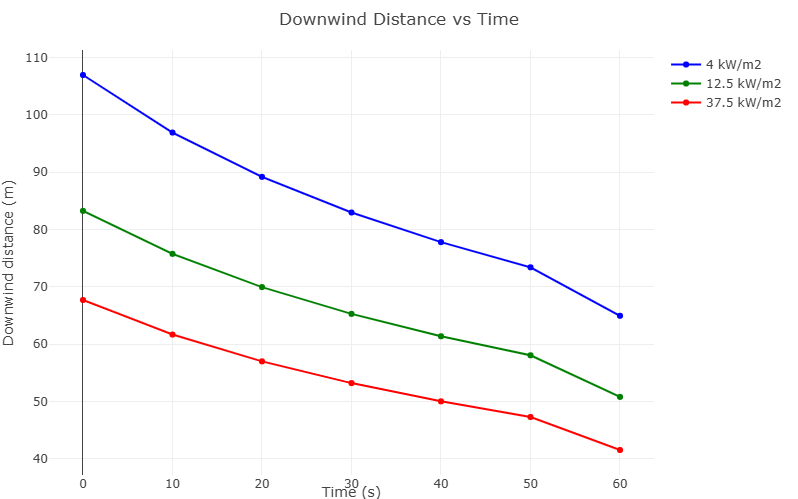

In [12]:
const traces: Partial<Plotly.PlotData>[] = [
    {
        x: distancesData.times,
        y: distancesData["4 kW/m2"],
        type: "scatter",
        mode: "lines+markers",
        name: "4 kW/m2",
        line: { color: "blue" }
    },
    {
        x: distancesData.times,
        y: distancesData["12.5 kW/m2"],
        type: "scatter",
        mode: "lines+markers",
        name: "12.5 kW/m2",
        line: { color: "green" }
    },
    {
        x: distancesData.times,
        y: distancesData["37.5 kW/m2"],
        type: "scatter",
        mode: "lines+markers",
        name: "37.5 kW/m2",
        line: { color: "red" }
    }
];

const layout: Partial<Plotly.Layout> = {
    title: "Downwind Distance vs Time",
    xaxis: { title: "Time (s)" },
    yaxis: { title: "Downwind distance (m)" },
    width: 800,
    height: 500
};

await Plotly.newPlot(tslab, traces, layout);

## Plot the contour points
The DistancesAndEllipsesToRadiationLevelsCalculation object has a contourPoints property. This is a list of LocalPosition, which itself has x, y and z properties.

**Note:** Since the DistancesAndEllipsesToRadiationLevelsCalculation supports multiple FlammableOutputConfigs, the contourPoints are appended together. There are always 50 points per FlammableOutputConfig and the order is always the same order as that in which the FlammableOutputConfigs were passed in.

For information, contour data for dispersion does not always contain 50 points; it varies depending on the scenario.

In [13]:
const radiationLevels = [4, 12.5, 37.5];

// Extract contour points for the first time step (t=0) as an example
const firstTimeCalculation = radiationCalculations[0];
const contourPoints = firstTimeCalculation.contourPoints!;

console.log(`Total contour points for t=0: ${contourPoints.length}`);
console.log(`Points per radiation level: 50`);
console.log(`Radiation levels: ${radiationLevels.join(", ")} kW/m2`);

// Display first few points for 4 kW/m2 (first 50 points)
console.log("\nFirst 10 contour points for 4 kW/m2 at t=0:");
console.log("Point\tX (m)\t\tY (m)");
console.log("-----\t-----\t\t-----");
for (let i = 0; i < 10; i++) {
    const point = contourPoints[i];
    console.log(`${i}\t${point.x.toFixed(6)}\t${point.y.toFixed(6)}`);
}

Total contour points for t=0: 150
Points per radiation level: 50
Radiation levels: 4, 12.5, 37.5 kW/m2

First 10 contour points for 4 kW/m2 at t=0:
Point	X (m)		Y (m)
-----	-----		-----
0	106.930060	0.000000
1	106.462937	9.452474
2	105.069238	18.749739
3	102.771847	27.739134
4	99.608487	36.273053
5	95.631101	44.211369
6	90.904998	51.423736
7	85.507779	57.791726
8	79.528067	63.210778
9	73.064049	67.591910


Now let's create a visualization showing how the radiation contours change over time...

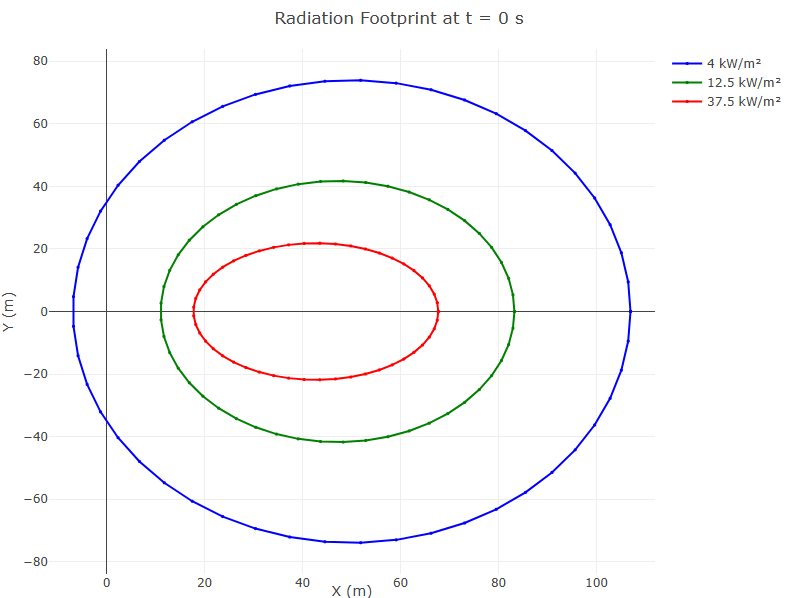

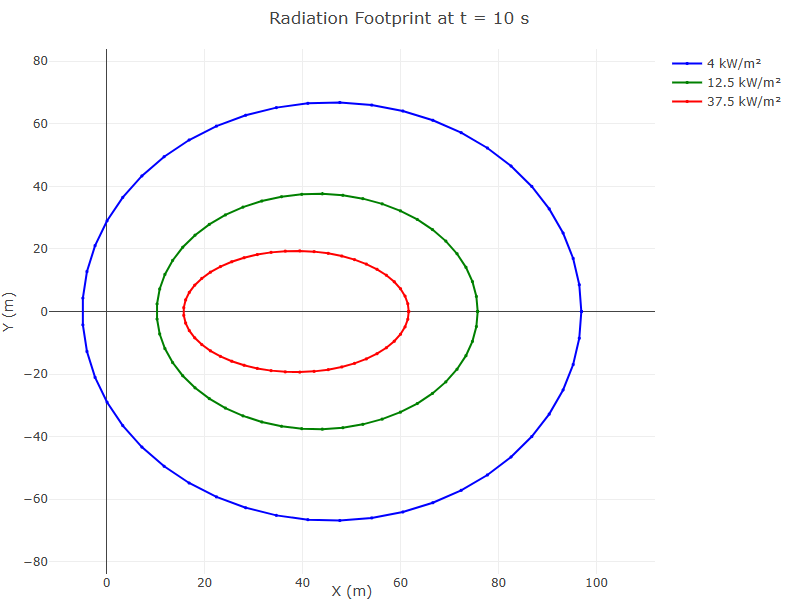

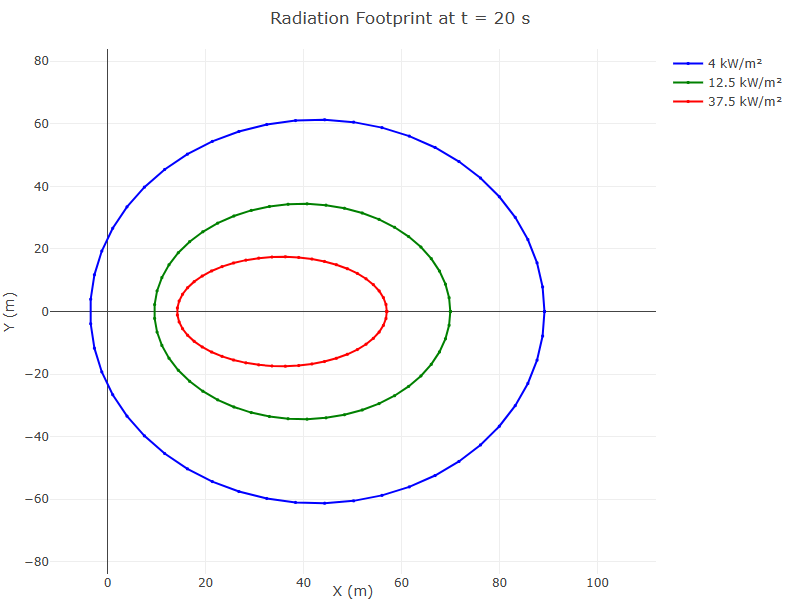

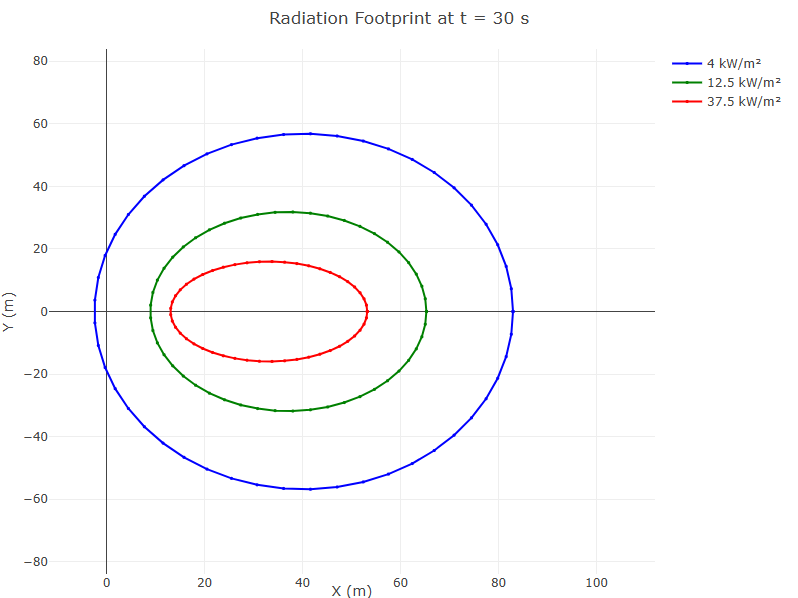

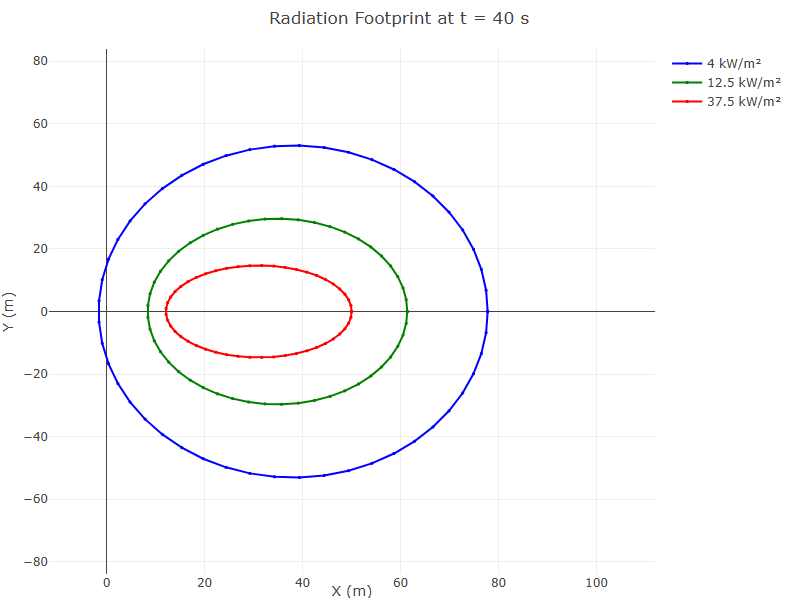

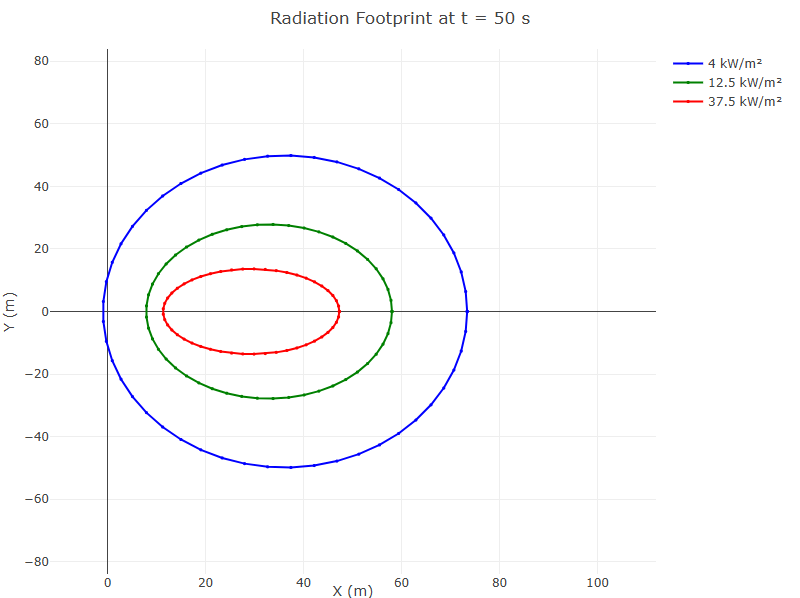

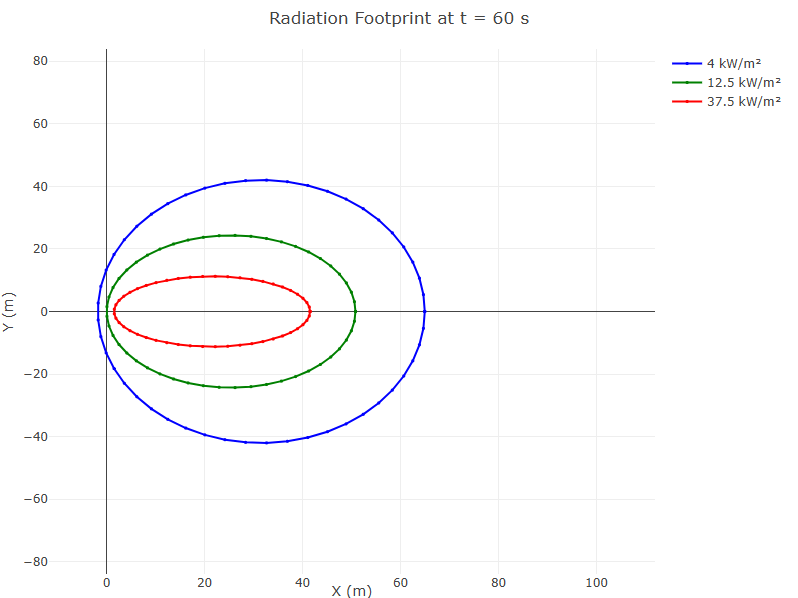

In [18]:
const xBuffer = 5;
const yBuffer = 10;

// Determine axis limits
let minX = Infinity, maxX = -Infinity, minY = Infinity, maxY = -Infinity;

for (const calculation of radiationCalculations) {
    for (const point of calculation.contourPoints!) {
        minX = Math.min(minX, point.x);
        maxX = Math.max(maxX, point.x);
        minY = Math.min(minY, point.y);
        maxY = Math.max(maxY, point.y);
    }
}

const colors = ['blue', 'green', 'red'];

// Plot each time step as its own chart
for (let timeIdx = 0; timeIdx < timesOfInterest.length; timeIdx++) {
    const calculation = radiationCalculations[timeIdx];
    const frameTraces: Partial<Plotly.PlotData>[] = [];

    for (let levelIdx = 0; levelIdx < radiationLevels.length; levelIdx++) {
        const startIdx = levelIdx * 50;
        const endIdx = startIdx + 50;

        const xValues: number[] = [];
        const yValues: number[] = [];

        for (let pointIdx = startIdx; pointIdx < endIdx; pointIdx++) {
            const point = calculation.contourPoints![pointIdx];
            xValues.push(point.x);
            yValues.push(point.y);
        }

        // Close the contour
        xValues.push(xValues[0]);
        yValues.push(yValues[0]);

        frameTraces.push({
            x: xValues,
            y: yValues,
            type: "scatter",
            mode: "lines+markers",
            name: `${radiationLevels[levelIdx]} kW/m²`,
            line: { color: colors[levelIdx] },
            marker: { size: 3 }
        });
    }

    const layout: Partial<Plotly.Layout> = {
        title: `Radiation Footprint at t = ${timesOfInterest[timeIdx]} s`,
        xaxis: {
            title: "X (m)",
            range: [minX - xBuffer, maxX + xBuffer]
        },
        yaxis: {
            title: "Y (m)",
            range: [minY - yBuffer, maxY + yBuffer]
        },
        width: 800,
        height: 600,
        showlegend: true
    };

    await Plotly.newPlot(tslab, frameTraces, layout);
}